<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-библиотек" data-toc-modified-id="Загрузка-данных-и-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и библиотек</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Анализ." data-toc-modified-id="Анализ.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ.</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Частотный-анализ" data-toc-modified-id="Частотный-анализ-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Частотный анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Bert" data-toc-modified-id="Bert-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bert</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# План работы.

Работа организована следуюшим образом.
- В первой главе загружаем библиотеки и данные. Проверяем что данные соответствуют описанию.
- Во всторой главе подготавливаем данные для обучения моделей. Исходые данные проверяем на коррекстность, затем тексты лемматизирунм и превращаем в вектора признаков. Разбиваем на выборки.

## Загрузка данных и библиотек

In [75]:
!pip install lightgbm -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  -q
!pip install --upgrade Pillow==9.5.0 -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [76]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix) 
from sklearn.inspection import permutation_importance
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import notebook
import torch
import re

from lightgbm import LGBMClassifier
import transformers
from scipy.sparse import csr_matrix
import spacy
from wordcloud import WordCloud

RANDOM_STATE = 42
TRAIN_SIZE = 0.2

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
if os.path.exists('/datasets/toxic_comments.csv'):
    df = pd.read_csv('/datasets/toxic_comments.csv',index_col='Unnamed: 0') 
else:
    print('Ошибка')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Вывод: данные загружены и соответствуют описанию.

## Подготовка

Подготовим данные для обучения моделей.

### Предобработка

Посмотрим есть ли дубликаты, пропуски и бинарно ли содержание столбца toxic.

In [8]:
df.duplicated().sum()

0

In [9]:
df.index.duplicated().sum()

0

In [10]:
df['toxic'].unique()

array([0, 1])

In [11]:
df.loc[df['text']=='']

,text,toxic


### Анализ.

Посмотрим соотношение токсичных и нетоксичных комментариев.

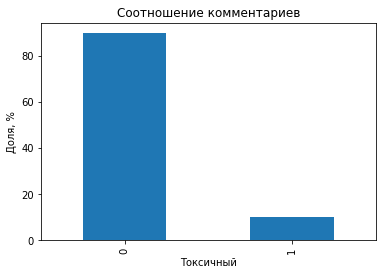

In [12]:
(df.pivot_table(index='toxic',values='text',aggfunc='count')
 /df.shape[0]*100).plot(kind = 'bar',legend=False)

plt.title('Соотношение комментариев')
plt.xlabel('Токсичный')
plt.ylabel('Доля, %')
plt.show()

Присутствует дисбаланс классов. На этапе разделения на выборки стоит использовать стратификацию.

Длина текстов и слов в зависимости от токсичности.

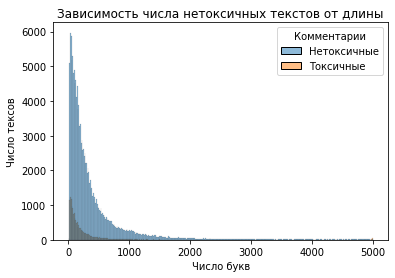

In [13]:
df['len']= df['text'].str.len()

fig, ax1 = plt.subplots()
sns.histplot(data=df, x='len', hue='toxic', common_norm=True, ax=ax1)
ax1.set_title(f'Зависимость числа нетоксичных текстов от длины')
ax1.set_xlabel('Число букв')
ax1.set_ylabel('Число тексов')
legend = ax1.get_legend()
handles = legend.legendHandles
ax1.legend(handles, ['Нетоксичные', 'Токсичные'], title='Комментарии')

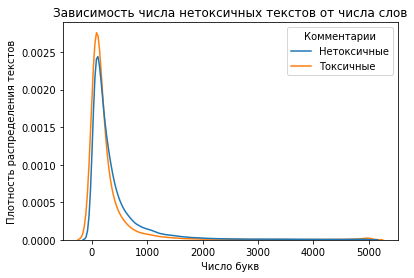

In [14]:

df_kde = df.loc[df['len']<5000]
fig, ax1 = plt.subplots()
sns.kdeplot(data=df_kde,x='len',hue='toxic',common_norm=False)
ax1.set_title(f'Зависимость числа нетоксичных текстов от числа слов')
ax1.set_xlabel('Число букв')
ax1.set_ylabel('Плотность распределения текстов')
legend = ax1.get_legend()
handles = legend.legendHandles
ax1.legend(handles, ['Нетоксичные', 'Токсичные'], title='Комментарии')
plt.show()

Видно, что длина текстов имет зависимость от токисчности. Токсичный в основной массе короче , но есть больше доля текстов максимальной длины.

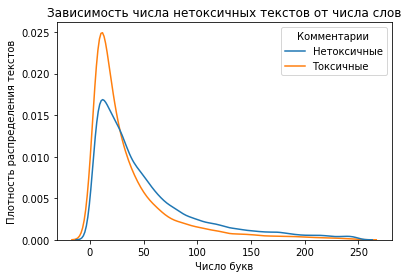

In [15]:
df['len_w']= df['text'].str.split().agg([len])


df_kde = df.loc[df['len_w']<250]
fig, ax1 = plt.subplots()
sns.kdeplot(data=df_kde,x='len_w',hue='toxic',common_norm=False)
ax1.set_title(f'Зависимость числа нетоксичных текстов от числа слов')
ax1.set_xlabel('Число букв')
ax1.set_ylabel('Плотность распределения текстов')
legend = ax1.get_legend()
handles = legend.legendHandles
ax1.legend(handles, ['Нетоксичные', 'Токсичные'], title='Комментарии')
plt.show()

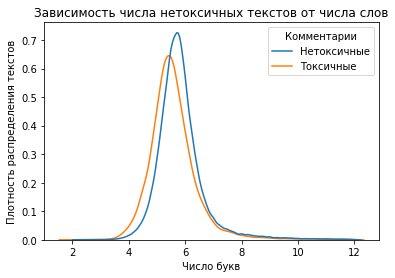

In [16]:
df['len_aw']= df['len']/df['len_w']

df_kde = df.loc[df['len_aw']<12]
fig, ax1 = plt.subplots()
sns.kdeplot(data=df_kde,x='len_aw',hue='toxic',common_norm=False)
ax1.set_title(f'Зависимость числа нетоксичных текстов от числа слов')
ax1.set_xlabel('Число букв')
ax1.set_ylabel('Плотность распределения текстов')
legend = ax1.get_legend()
handles = legend.legendHandles
ax1.legend(handles, ['Нетоксичные', 'Токсичные'], title='Комментарии')
plt.show()

В длине слов тоже видно есть отличия. 

### Лемматизация

Леммптизируем тексты и оставим в них только английские символы и пробелы.(Процедула долгая в тренажере ~40мин)

In [17]:
# Загрузка модели английского языка
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

In [18]:
tqdm.pandas()

# Лемматизация текста
def lemmatize(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]',' ',text.lower()).split())

df_lem_series = df['text'].progress_apply(lambda x: lemmatize(clear_text(x)))
df_lem = df_lem_series.to_frame(name='text')

  0%|          | 0/159292 [00:00<?, ?it/s]

In [73]:
df_lem['toxic'] = df['toxic']
df_lem.head()

,text,len,toxic
0,explanation why the edit make under my usernam...,264,0
1,d aww he match this background colour I m seem...,112,0
2,hey man I m really not try to edit war it s ju...,233,0
3,more I can t make any real suggestion on impro...,622,0
4,you sir be my hero any chance you remember wha...,67,0


### Частотный анализ

Нарисуем облоко слов)

In [77]:
lem = df_lem['text'].astype('str')
text_raw = " ".join(df_lem.loc[df_lem['toxic']==1,'text'].astype('str'))
wordcloud = WordCloud(collocations=False).generate(text_raw)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Облако слов для токсичных текстов')
plt.show()

AttributeError: 'ImageDraw' object has no attribute 'textsize'

In [ ]:
lem = df_lem['text'].astype('str')
text_raw = " ".join(df_lem.loc[df_lem['toxic']==0,'text'].astype('str'))
wordcloud = WordCloud().generate(text_raw)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Облако слов для не токсичных текстов')
plt.axis('off')
plt.show()

### Вывод

Данные готовы для обучения. При разделении выборок нужно учесть дисбаланс классов.

## Обучение

Разделяем учебную и тренировочную выборку.

In [33]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))


txt = ['text']
num = ['len']

df_lem = df_lem.drop('toxic',axis=1)
df_lem['text'] = df_lem['text'].astype('str')
df_lem['len'] = df['len']

X_train,X_test,y_train,y_test = train_test_split(df_lem,df['toxic'],stratify=df['toxic'], test_size=0.2,random_state=RANDOM_STATE)
X_train.shape

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(127433, 2)

Создаем пайплайн для обучения и выбора гипермараметров моделей
- Логистическая регрессия
- Решающие деревья
- Градиентный бустинг.

In [34]:
tf_pipe = Pipeline(
    [
        (
            'tf', 
            TfidfVectorizer(stop_words=list(stopwords))
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('vect', tf_pipe ,'text'),
        ('num', RobustScaler(), num)
    ], 
    remainder='passthrough'
)


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)], 
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 3)],
        'models__min_samples_leaf': range(2 , 3),
        'models__min_samples_split': range(2 , 3),
    },
    # словарь для модели LGBMClassifier()
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__num_leaves': range(15,20),
        'models__max_depth': [None] + [i for i in range(8, 12)], 
        'models__learning_rate': [0.4,0.45],
    }
]

In [35]:
%%time
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=1,
    n_iter=15,
    random_state=RANDOM_STATE
)
random_search.fit(X_train, y_train)

print ('Метрика лучшей модели при кросс-валидации:', random_search.best_score_)
print('Лучшая модель и её параметры:')
display(random_search.best_estimator_)
random_search.best_params_

Метрика лучшей модели при кросс-валидации: 0.7702534052799997
Лучшая модель и её параметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vect',
                                                  Pipeline(steps=[('tf',
                                                                   TfidfVectorizer(stop_words=['each',
                                                                                               't',
                                                                                               'their',
                                                                                               'as',
                                                                                               'when',
                                                                                               'has',
                                                                                               "should've",
                                                       

CPU times: user 1h 19min 23s, sys: 17.8 s, total: 1h 19min 41s
Wall time: 1h 19min 48s


{'models__num_leaves': 19,
 'models__max_depth': None,
 'models__learning_rate': 0.45,
 'models': LGBMClassifier(learning_rate=0.45, max_depth=None, num_leaves=19,
                random_state=42)}

Для лучшей модели смотрим метрику F1 и матрицу ошибок.

In [36]:
y_test_pred = random_search.best_estimator_.predict(X_test)
print(f'Метрика F1 на тестовой выборке : {f1_score(y_test, y_test_pred)}')

Метрика F1 на тестовой выборке : 0.7717671303451831


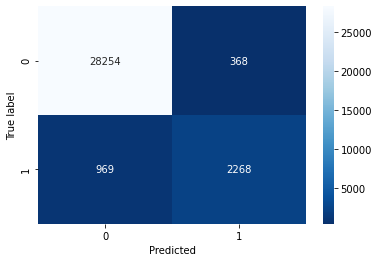

In [27]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

Итого лучшей моделью из 3х оказался градиентный бустинг с параметрами LGBMClassifier(learning_rate=0.45, max_depth=None, num_leaves=19} при этом метрика F1 на тренировочной выборке 77 что выше требуемого минимума.

Посмотрим самые важные признаки.

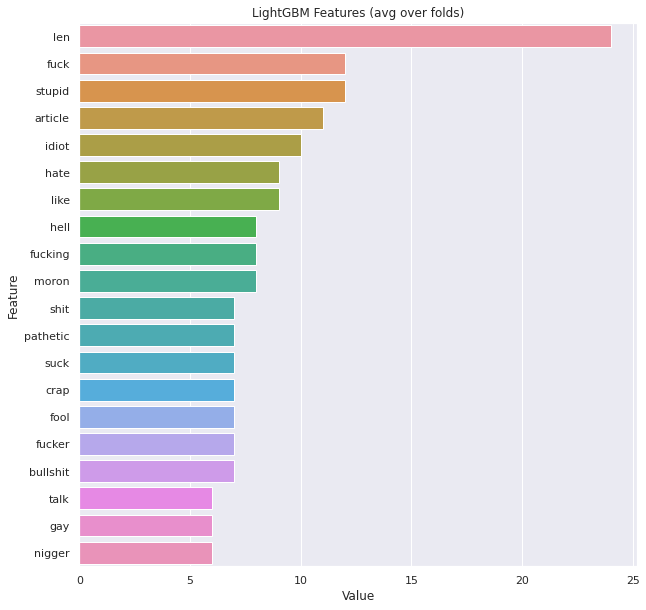

In [65]:
word_list_best = random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['vect'].named_steps['tf'].get_feature_names()
word_list_best.append('len')


def plotImp(model, num = 20, fig_size = (10, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':word_list_best})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Важность признаков LightGBM')
    plt.show()

plotImp(random_search.best_estimator_.named_steps['models'])


Посмотрим самые важные признаки для логистической регресии.

In [68]:
X_train = X_train['text']
X_test = X_test['text']

tf_vectorizer = TfidfVectorizer(stop_words=list(stopwords))

X_train_t = tf_vectorizer.fit_transform(X_train)
X_test_t = tf_vectorizer.transform(X_test)

model = LogisticRegression(random_state=RANDOM_STATE,max_iter=200)

model.fit(X_train_t, y_train)

y_pred_lr = model.predict(X_train_t)

print ('Метрика  модели :', f1_score(y_train,y_pred_lr))

Метрика  модели : 0.7723599632690543


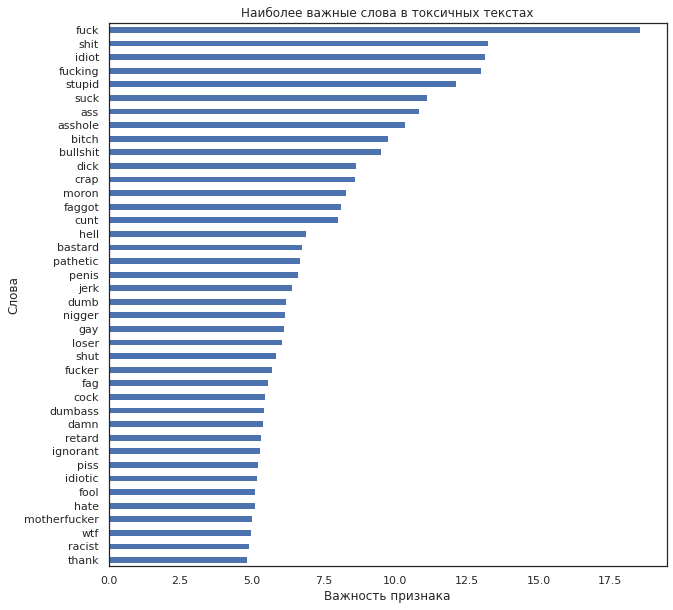

In [69]:
tf_col = pd.DataFrame(list(tf_vectorizer.vocabulary_.items()),
                      columns = ['word','num']).sort_values(by='num').set_index('num')
word_list = tf_col['word']

coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': word_list, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True).tail(40)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10),legend=False)
plt.title(f'Наиболее важные слова в токсичных текстах')
plt.xlabel('Важность признака')
plt.ylabel('Слова')
    
    
plt.show()

Действительно токсичные слова.

## Bert

Хотелось бы так же попробовать эту модель. Но теория дана весьма схемотично, по этому в деталях не понятно как это делать. Код ниже видимо локально у меня работает , но крайне медленно. Оценочно просит 100 часов. По этому на полном датасете запускать не буду.

Инициализируем токенизатор со английским словарем по ссылке.

In [ ]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
#model.to('cuda')

Токенизируем датафрейм. 

In [ ]:
%%time

df_t, _ = train_test_split(df, stratify=df['toxic'],train_size=2000.0/df.shape[0],random_state=42)

tokenized = df_t['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized.shape

Создаем массивы из токенизированныз значений. Поскольку BERT работает только с 512 токенами, то обрезаем вектора до этой длины.

In [ ]:
%%time
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])[:,:512]

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

Создаем матрицу признаков. Делаем визуализацию прогресса.

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        #batch = batch.to('cuda')
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        #attention_mask_batch = attention_mask_batch.to('cuda')
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        #   tb = batch_embeddings[0][:,0,:].to('cpu')
        embeddings.append(tb.numpy())
features = np.concatenate(embeddings)
features.shape

Обучаем на матрице признаков модель и делаем предсказание.

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(features, df_t['toxic'], train_size=0.8,random_state=42)
logreg = LogisticRegression(random_state=RANDOM_STATE,max_iter=400)
logreg.fit(X_train,y_train)
y_test_pred = logreg.predict(X_test)
print(f'Метрика F1 на тестовой выборке : {f1_score(y_test, y_test_pred)}')

Метрика F1 на тестовой выборке : 0.977

## Выводы

В работе требовалось предоставить  магазину «Викишоп» обученную модель, которая будет искать токсичные комментарии и отправлять их на модерацию. При этом значение метрики качества F1 должно быть не меньше 0.75. 

Для решения этой задачи был предоставлен датафрейм с комментариями и известной оценкой токсичности. В начале исходные данные были проверены на корректность с точки зрения дубликатов пропусков и содержимого оценки токсичности.
Затем каждый текст был лемматизирован и очишен от посторонних символов и стопслов.
После этого для каждого текста был составлен вектор из мер DT-IDF. Полученная таблица была разбита на тренировочную и тестовую выборку. Далее на этих выборкая были обучены модели
- Логистическая регрессия
- Решающие деревья
- Градиентный бустинг
и выбранна лучшая с учетом гиперпараметров. 

Лучшей моделью из 3х оказался градиентный бустинг с параметрами LGBMClassifier(learning_rate=0.4, max_depth=None, num_leaves=17) при этом метрика F1 на тренировочной выборке 77 что выше требуемого минимума.
Однако стоит заметить, что довольно большая часть токсичных комментариев не была найдена моделью по этому возможно стоит сменить метрику на Recall или $F_{\beta}$ с уклоном в Recall.

Связка BERT с логистической регресией оказалось гораздо эффективнее при обучении всего на ~2000 текстах Метрика F1 на тестовой выборке : 0.977.